In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import os, copy, random
import matplotlib.pyplot as plt
import collections
import scipy.io
import gzip
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

n_mnist_file = './dataset/n_mnist/mnist-with-awgn.mat'

data = scipy.io.loadmat(n_mnist_file)
X_train = data['train_x']
y_train = data['train_y']
X_test = data['test_x']
y_test = data['test_y']
print('train dataset: {} {}'.format(len(X_train), len(y_train)))
print('test dataset: {} {}'.format(len(X_test), len(y_test)))

train dataset: 60000 60000
test dataset: 10000 10000


(784,)
2


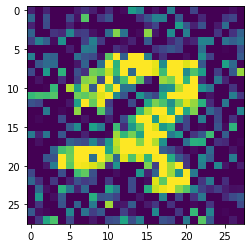

In [2]:
# reformat label data.
y_train = np.array([int(np.where(y_train[i] == 1)[0]) for i in range(len(y_train))])
y_test = np.array([int(np.where(y_test[i] == 1)[0]) for i in range(len(y_test))])
# visualize and check data and label.
classes=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
index = 30
print(X_train[0].shape)
plt.imshow(X_train[index].reshape(28,28))
print(classes[y_train[index]])

In [3]:
# count number of each class -> check data balance.
train_count = collections.Counter(y_train)
print(train_count)
test_count = collections.Counter(y_test)
print(test_count)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [4]:
#make this reproducible with seed fixed
np.random.seed(42)

#subsampling each class
subset_X_train = []
subset_y_train = []
subset_per_each_train = 600
for i in range(len(classes)):
    _class_idx = np.where(y_train == i)[0]
    print('sampled from class {} : {}'.format(i, len(_class_idx)))
    np.random.shuffle(_class_idx)
    subset_X_train.extend(X_train[_class_idx[:subset_per_each_train]])
    subset_y_train.extend(y_train[_class_idx[:subset_per_each_train]])

subset_X_test = []
subset_y_test = []
subset_per_each_test = 100
for i in range(len(classes)):
    _class_idx = np.where(y_test == i)[0]
    print('sampled from class {} : {}'.format(i, len(_class_idx)))
    np.random.shuffle(_class_idx)
    subset_X_test.extend(X_train[_class_idx[:subset_per_each_test]])
    subset_y_test.extend(y_train[_class_idx[:subset_per_each_test]])

print(len(subset_X_train), len(subset_y_train))
print(len(subset_X_test), len(subset_y_test))

scaler = StandardScaler()
subset_X_train = scaler.fit_transform(np.array(subset_X_train))
subset_y_train = np.array(subset_y_train)
subset_X_test = scaler.fit_transform(np.array(subset_X_test))
subset_y_test = np.array(subset_y_test)


sampled from class 0 : 5923
sampled from class 1 : 6742
sampled from class 2 : 5958
sampled from class 3 : 6131
sampled from class 4 : 5842
sampled from class 5 : 5421
sampled from class 6 : 5918
sampled from class 7 : 6265
sampled from class 8 : 5851
sampled from class 9 : 5949
sampled from class 0 : 980
sampled from class 1 : 1135
sampled from class 2 : 1032
sampled from class 3 : 1010
sampled from class 4 : 982
sampled from class 5 : 892
sampled from class 6 : 958
sampled from class 7 : 1028
sampled from class 8 : 974
sampled from class 9 : 1009
6000 6000
1000 1000


In [5]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(subset_X_train, subset_y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

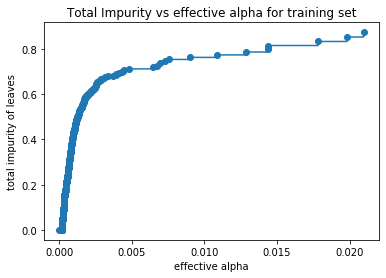

In [6]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [8]:
print(len(ccp_alphas))
ccp_alpha_round = [np.around(num, 4) for num in ccp_alphas]
print(ccp_alphas[:10])
print(ccp_alpha_round[:10])

ccp_alpha_list=[]
[ccp_alpha_list.append(x) for x in ccp_alpha_round if x not in ccp_alpha_list]
print(len(ccp_alpha_list))

1089
[0.         0.00016588 0.00016617 0.00016667 0.00016667 0.00016667
 0.00016667 0.00016667 0.00016667 0.00016667]
[0.0, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002]
51


In [9]:
clfs = []
for ccp_alpha in ccp_alpha_list:
    clf = GradientBoostingClassifier(random_state=42, ccp_alpha=ccp_alpha, max_features="sqrt", max_depth=10)
    clf.fit(subset_X_train, subset_y_train)
    clfs.append(clf)
    print('ccp_alpha', ccp_alpha)

ccp_alpha 0.0
ccp_alpha 0.0002
ccp_alpha 0.0003
ccp_alpha 0.0004
ccp_alpha 0.0005
ccp_alpha 0.0006
ccp_alpha 0.0007
ccp_alpha 0.0008
ccp_alpha 0.0009
ccp_alpha 0.001
ccp_alpha 0.0011
ccp_alpha 0.0012
ccp_alpha 0.0013
ccp_alpha 0.0014
ccp_alpha 0.0015
ccp_alpha 0.0016
ccp_alpha 0.0017
ccp_alpha 0.0018
ccp_alpha 0.0019
ccp_alpha 0.002
ccp_alpha 0.0021
ccp_alpha 0.0022
ccp_alpha 0.0023
ccp_alpha 0.0024
ccp_alpha 0.0025
ccp_alpha 0.0026
ccp_alpha 0.0027
ccp_alpha 0.0028
ccp_alpha 0.0029
ccp_alpha 0.0031
ccp_alpha 0.0033
ccp_alpha 0.0037
ccp_alpha 0.0039
ccp_alpha 0.0041
ccp_alpha 0.0043
ccp_alpha 0.0044
ccp_alpha 0.0045
ccp_alpha 0.0048
ccp_alpha 0.0065
ccp_alpha 0.0067
ccp_alpha 0.0069
ccp_alpha 0.0073
ccp_alpha 0.0076
ccp_alpha 0.009
ccp_alpha 0.0109
ccp_alpha 0.0129
ccp_alpha 0.0144
ccp_alpha 0.0178
ccp_alpha 0.0198
ccp_alpha 0.021
ccp_alpha 0.0263


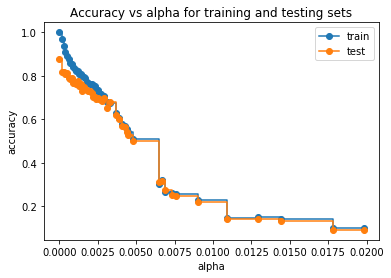

In [10]:
train_scores = [clf.score(subset_X_train, subset_y_train) for clf in clfs]
test_scores = [clf.score(subset_X_test, subset_y_test) for clf in clfs]

train_scores = train_scores[:-2]
test_scores = test_scores[:-2]
_ccp_alpha_list = ccp_alpha_list[:-2]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(_ccp_alpha_list, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(_ccp_alpha_list, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [11]:
parameters = {'max_features':['sqrt'], 'max_depth':[4, 6, 8, 10, 12], 'ccp_alpha':[0.001, 0.002, 0.003, 0.004 ,0.005]}
clf = GradientBoostingClassifier(random_state=42)
clf_GS = GridSearchCV(clf, parameters, verbose=2, cv=10, n_jobs=-1)
clf_GS.fit(subset_X_train, subset_y_train)


Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.001, 0.002, 0.003, 0.004, 0.005],
                         'max_depth': [4, 6, 8, 10, 12],
                         'max_features': ['sqrt']},
             verbose=2)

In [13]:
print(clf_GS.best_params_)

{'ccp_alpha': 0.001, 'max_depth': 12, 'max_features': 'sqrt'}


In [14]:
subset_y_test_pred = clf_GS.best_estimator_.predict(subset_X_test)
test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
print('Test Accuracy of best model: {}'.format(test_acc))

Test Accuracy of best model: 0.784


In [19]:
t_list=[]
for i in range(len(clf_GS.cv_results_['params'])):
    if (clf_GS.cv_results_['params'][i]['ccp_alpha'] == 0.005):
        t_list.append(clf_GS.cv_results_['mean_test_score'][i])
print(t_list)

[0.4826666666666667, 0.47700000000000004, 0.487, 0.48250000000000004, 0.48283333333333334]


In [32]:
#for learning rate analysis change subset_per_each_train as 100, 200, 300, 400, 500, 600

#make this reproducible with seed fixed
np.random.seed(42)

#subsampling each class
subset_X_train = []
subset_y_train = []
subset_per_each_train = 600
for i in range(len(classes)):
    _class_idx = np.where(y_train == i)[0]
    print('sampled from class {} : {}'.format(i, len(_class_idx)))
    np.random.shuffle(_class_idx)
    subset_X_train.extend(X_train[_class_idx[:subset_per_each_train]])
    subset_y_train.extend(y_train[_class_idx[:subset_per_each_train]])

print(len(subset_X_train), len(subset_y_train))
print(len(subset_X_test), len(subset_y_test))

scaler = StandardScaler()
subset_X_train = scaler.fit_transform(np.array(subset_X_train))
subset_y_train = np.array(subset_y_train)

sampled from class 0 : 5923
sampled from class 1 : 6742
sampled from class 2 : 5958
sampled from class 3 : 6131
sampled from class 4 : 5842
sampled from class 5 : 5421
sampled from class 6 : 5918
sampled from class 7 : 6265
sampled from class 8 : 5851
sampled from class 9 : 5949
6000 6000
1000 1000


In [31]:
l_clf = GradientBoostingClassifier(max_depth=12, max_features='sqrt', ccp_alpha=0.001, random_state=42)
l_clf.fit(subset_X_train, subset_y_train)
subset_y_test_pred = l_clf.predict(subset_X_test)
train_score = l_clf.score(subset_X_train, subset_y_train)
test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
print('Train score {:.4f} Test Accuracy of best model: {}'.format(train_score, test_acc))

Train score 0.9920 Test Accuracy of best model: 0.653


In [5]:
#performance
import time
t1 = time.time()
l_clf = GradientBoostingClassifier(max_depth=12, max_features='sqrt', ccp_alpha=0.001, random_state=42)
l_clf.fit(subset_X_train, subset_y_train)
end_t1 = time.time()
train_score = l_clf.score(subset_X_train, subset_y_train)
t2 = time.time()
subset_y_test_pred = l_clf.predict(subset_X_test)
#test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
end_t2 = time.time()
print('Train time {:.4f} Test time {:.4f}'.format((end_t1 - t1), (end_t2 - t2)))

Train time 153.4386 Test time 0.0151
